# Causal Effect Estimation in datasets

This notebook serves as a demonstration of the `CausalEffectEstimation` module for estimating causal effects on both generated and real datasets.

| | | |
|-|-|-|
|[ ![Creative Commons License](images/cc4.png)](http://creativecommons.org/licenses/by-nc/4.0/) |[ ![aGrUM](images/logoAgrum.png)](https://agrum.org) |[ ![interactive online version](images/atbinder.svg)](https://agrum.gitlab.io/extra/agrum_at_binder.html)

In [1]:
import pyagrum as gum
import pyagrum.lib.discretizer as disc
import pyagrum.lib.notebook as gnb
import pyagrum.lib.explain as gexpl

import pyagrum.causal as csl
import pyagrum.causal.notebook as cslnb

import numpy as np
import pandas as pd

## 1. ACE estimations from generated RCT data

To estimate the Average Causal Effects (ACE) from data generated under conditions resembling a Randomized Controlled Trial (RCT), we define two generative models. 

### 1.1 Dataset

Consider two generative models:

* A linear generative model described by the equation:
$$ Y = 3X_1 + 2X_2 -2X_3 -0.8X_4 + T(2X_1 + 5X_3 +3X_4) $$

* And a non-linear generative model described by the equation:
$$ Y = 3X_1 + 2X_2^2 -2X_3 -0.8X_4 +10T $$


Where $ (X_1,X_2,X_3,X_4) \sim \mathcal{N}_4((1,1,1,1), I_4) $, $T \sim \mathcal{Ber}(1/2)$ and $ (X_1,X_2,X_3,X_4,T) $ are jointly independent in both of the models.

Data from the models can be obtatined by the functions given below.

In [2]:
def linear_simulation(n: int = 100000, sigma: float = 1) -> pd.DataFrame:
  """
  Returns n observations from the linear model with normally distributed
  noise with expected value 0 and standard deviation sigma.
  """

  X1 = np.random.normal(1, 1, n)
  X2 = np.random.normal(1, 1, n)
  X3 = np.random.normal(1, 1, n)
  X4 = np.random.normal(1, 1, n)
  epsilon = np.random.normal(0, sigma, n)
  T = np.random.binomial(1, 0.5, n)
  Y = 3 * X1 + 2 * X2 - 2 * X3 - 0.8 * X4 + T * (2 * X1 + 5 * X3 + 3 * X4) + epsilon
  d = np.array([T, X1, X2, X3, X4, Y])
  df_data = pd.DataFrame(data=d.T, columns=["T", "X1", "X2", "X3", "X4", "Y"])
  df_data["T"] = df_data["T"].astype(int)

  return df_data


def non_linear_simulation(n: int = 100000, sigma: float = 1) -> pd.DataFrame:
  """
  Returns n observations from the non-linear model with normally distributed
  noise with expected value 0 and standard deviation sigma.
  """

  X1 = np.random.normal(1, 1, n)
  X2 = np.random.normal(1, 1, n)
  X3 = np.random.normal(1, 1, n)
  X4 = np.random.normal(1, 1, n)
  epsilon = np.random.normal(0, sigma, n)
  T = np.random.binomial(1, 0.5, n)
  Y = 3 * X1 + 2 * X2**2 - 2 * X3 - 0.8 * X4 + 10 * T + epsilon
  d = np.array([T, X1, X2, X3, X4, Y])
  df_data = pd.DataFrame(data=d.T, columns=["T", "X1", "X2", "X3", "X4", "Y"])
  df_data["T"] = df_data["T"].astype(int)

  return df_data

Furthermore, the expected values of $Y(0)$ and $Y(1)$ can be explicitly calculated, providing us the theoretical ACE of $\tau = 10$ which will serve as a point of reference for the estimations.

We will explore how the `CausalEffectEstimation` module can estimate the causal effect of $T$ on $Y$ in both of the generated datasets.

### 1.2 Setup

First, genereate the data using the previously defined functions, and specify the causal graph of the variables. A single graph will be applicable to both datasets, as they share the same variables and causal structure.

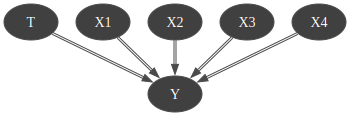

In [3]:
linear_data = linear_simulation()
non_linear_data = non_linear_simulation()

bn = gum.fastBN("Y<-T; Y<-X1; Y<-X2; Y<-X3; Y<-X4")
causal_model = csl.CausalModel(bn)

cslnb.showCausalModel(causal_model, size="10")

If the `CausalBNEstimator` estimation method is not employed for estimation process, the model generated using `gum.fastBN` will suffice, as only the graph structure of the Causal Bayesian Network will be used for causal identification.

However, if the Causal Bayesian Network estimator is utilized, it will be necessary to provide a `csl.CausalModel` object with appropriate discretization, as the Conditional Probability Tables of the model will be used for estimation. Here we use the `discretizer` module to perform this task, the arcs are added manually.

Selecting an optimal discretization is crucial: a coarse discretization may lead to poor estimation due to its inability to capture fine variations in the distribution, while an overly fine discretization may result in too many parameters, making it difficult for the parameter learning algorithm to accurately estimate the distribution. Therefore, the discretization should strike a balance, being neither too coarse nor too fine.

In [4]:
discretizer = disc.Discretizer(defaultDiscretizationMethod="uniform", defaultNumberOfBins=20)
disc_bn = discretizer.discretizedTemplate(linear_data)

disc_bn.beginTopologyTransformation()
for node in {"T", "X1", "X2", "X3", "X4"}:
  disc_bn.addArc(node, "Y")
disc_bn.endTopologyTransformation()

disc_causal_model = csl.CausalModel(disc_bn)

for id, _ in disc_bn:
  print(disc_bn.variable(id))

T:Range([0,1])
X1:Discretized(<(-3.0406;-2.61836[,[-2.61836;-2.19612[,[-2.19612;-1.77387[,[-1.77387;-1.35163[,[-1.35163;-0.929393[,[-0.929393;-0.507152[,[-0.507152;-0.0849111[,[-0.0849111;0.33733[,[0.33733;0.759571[,[0.759571;1.18181[,[1.18181;1.60405[,[1.60405;2.02629[,[2.02629;2.44853[,[2.44853;2.87077[,[2.87077;3.29302[,[3.29302;3.71526[,[3.71526;4.1375[,[4.1375;4.55974[,[4.55974;4.98198[,[4.98198;5.40422)>)
X2:Discretized(<(-3.24866;-2.81784[,[-2.81784;-2.38702[,[-2.38702;-1.95619[,[-1.95619;-1.52537[,[-1.52537;-1.09454[,[-1.09454;-0.663721[,[-0.663721;-0.232898[,[-0.232898;0.197926[,[0.197926;0.628749[,[0.628749;1.05957[,[1.05957;1.4904[,[1.4904;1.92122[,[1.92122;2.35204[,[2.35204;2.78287[,[2.78287;3.21369[,[3.21369;3.64451[,[3.64451;4.07534[,[4.07534;4.50616[,[4.50616;4.93698[,[4.93698;5.36781)>)
X3:Discretized(<(-3.94929;-3.48918[,[-3.48918;-3.02908[,[-3.02908;-2.56897[,[-2.56897;-2.10886[,[-2.10886;-1.64876[,[-1.64876;-1.18865[,[-1.18865;-0.728545[,[-0.728545;-0.268439[,[-0.268

We are now prepared to instantiate the `CausalEffectEstimation` object for both datasets.

In [5]:
linear_cee = csl.CausalEffectEstimation(linear_data, disc_causal_model)
print(linear_cee)


 Dataframe	: <pandas.core.frame.DataFrame object at 0x10cecc440>
	- shape		: (100000, 6)
	- columns	: Index(['T', 'X1', 'X2', 'X3', 'X4', 'Y'], dtype='object')
	- memory usage	: 4.800132 MB
 Causal Model	: <pyagrum.causal._CausalModel.CausalModel object at 0x10cda6710>
	- names		: {0: 'T', 1: 'X1', 2: 'X2', 3: 'X3', 4: 'X4', 5: 'Y'}
	- causal BN	: BN{nodes: 6, arcs: 5, domainSize: 10^6.80618, dim: 6080077, mem: 48Mo 848Ko 656o}
	- observ. BN	: BN{nodes: 6, arcs: 5, domainSize: 10^6.80618, dim: 6080077, mem: 48Mo 848Ko 656o}


In [6]:
non_linear_cee = csl.CausalEffectEstimation(non_linear_data, disc_causal_model)
print(non_linear_cee)


 Dataframe	: <pandas.core.frame.DataFrame object at 0x11db834d0>
	- shape		: (100000, 6)
	- columns	: Index(['T', 'X1', 'X2', 'X3', 'X4', 'Y'], dtype='object')
	- memory usage	: 4.800132 MB
 Causal Model	: <pyagrum.causal._CausalModel.CausalModel object at 0x10cda6710>
	- names		: {0: 'T', 1: 'X1', 2: 'X2', 3: 'X3', 4: 'X4', 5: 'Y'}
	- causal BN	: BN{nodes: 6, arcs: 5, domainSize: 10^6.80618, dim: 6080077, mem: 48Mo 848Ko 656o}
	- observ. BN	: BN{nodes: 6, arcs: 5, domainSize: 10^6.80618, dim: 6080077, mem: 48Mo 848Ko 656o}


### 1.3 Causal Indentification

The subsequent step involves identifying the causal criterion to be used for estimation. This is crucial, as most estimators rely on strong assumptions regarding the underlying causal structure of the data-generating process. Incorrect specification of the adjustment may compromise the guarantee of asymptotic normality.

In [7]:
linear_cee.identifyAdjustmentSet(intervention="T", outcome="Y")
non_linear_cee.identifyAdjustmentSet(intervention="T", outcome="Y", verbose=False)

Randomized Controlled Trial adjustment found. 

Supported estimators include:
- CausalModelEstimator
- DM
If the outcome variable is a cause of other covariates in the causal graph,
Backdoor estimators may also be used.


'Randomized Controlled Trial'

Consistent with the data generation, the adjustment identified is the Randomized Control Trial adjustment. This yields a list of the various estimators supported by this adjustment.

### 1.4 Causal Effect Estimation

Once the adjustment is identified, we can proceed to estimation using the supported estimators. First, the estimator must be fitted to the data.

In [8]:
linear_cee.fitDM()
non_linear_cee.fitDM()

The estimation is obtained by calling the `estimateCausalEffect` method.

In [9]:
linear_tau_hat = linear_cee.estimateCausalEffect()
non_linear_tau_hat = non_linear_cee.estimateCausalEffect()

print(f"ACE linear = {linear_tau_hat}, MAPE = {abs((linear_tau_hat - 10) * 10)} %")
print(f"ACE non linear = {non_linear_tau_hat}, MAPE = {abs((non_linear_tau_hat - 10) * 10)} %")

ACE linear = 10.0166630569799, MAPE = 0.16663056979899338 %
ACE non linear = 9.919255125948562, MAPE = 0.8074487405143849 %


The difference-in-means estimator, which is the simplest estimator for the ACE, yields mostly accurate results. This is expected in an RCT environment where the treatment is independent of confounders, making intervention equivalent to observation.

### 1.5 User specified adjustment

If the user wish to apply an alternative adjustment, they may specify their own set of variables for each component of the adjustment. However, please note that such custom adjustments do not guarantee unbiased estimation and may not ensure an error-free estimation process.

In [10]:
linear_cee.useBackdoorAdjustment(intervention="T", outcome="Y", confounders={"X1", "X2", "X3", "X4"})
non_linear_cee.useBackdoorAdjustment(intervention="T", outcome="Y", confounders={"X1", "X2", "X3", "X4"})

In [11]:
linear_cee.fitSLearner()
non_linear_cee.fitSLearner()

In [12]:
linear_tau_hat = linear_cee.estimateCausalEffect()
non_linear_tau_hat = non_linear_cee.estimateCausalEffect()

print(f"ACE linear = {linear_tau_hat}, MAPE = {abs((linear_tau_hat - 10) * 10)} %")
print(f"ACE non linear = {non_linear_tau_hat}, MAPE = {abs((non_linear_tau_hat - 10) * 10)} %")

ACE linear = 10.001817516762518, MAPE = 0.018175167625180677 %
ACE non linear = 9.98866670238192, MAPE = 0.11333297618079996 %


In this case, RCT adjustment also supports Backdoor adjustment, we thus get mostly accurate estimations. Let's see how the estimation would be if we specify an uncompatible adjustment.

### 1.6 Incorrectly specified adjustment

We will use the frontdoor adjustment to illustrate the behaviours of incorrect specification. 

In [13]:
linear_cee.useFrontdoorAdjustment(intervention="T", outcome="Y", mediators={"X1", "X2", "X3", "X4"})
non_linear_cee.useFrontdoorAdjustment(intervention="T", outcome="Y", mediators={"X1", "X2", "X3", "X4"})

In [14]:
linear_cee.fitSimplePlugIn()
non_linear_cee.fitSimplePlugIn()

In [15]:
linear_tau_hat = linear_cee.estimateCausalEffect()
non_linear_tau_hat = non_linear_cee.estimateCausalEffect()

print(f"ACE linear = {linear_tau_hat}, MAPE = {abs((linear_tau_hat - 10) * 10)} %")
print(f"ACE non linear = {non_linear_tau_hat}, MAPE = {abs((non_linear_tau_hat - 10) * 10)} %")

ACE linear = 0.015331077515512, MAPE = 99.84668922484488 %
ACE non linear = -0.06970696354768799, MAPE = 100.69706963547688 %


As anticipated, using an incorrect adjustment set results in a heavily biased estimation. In this case, the ACE is close to zero, indicating that the estimator incorrectly predicts no causal effect of $T$ on $Y$.

### 1.7 Causal Bayesian Network Estimation

To fully utilize the causal model within the estimation process, we will now use the Conditional Probability Tables of the Causal Bayesian Network via the `CausalBNEstimator`, rather than relying solely on the underlying causal graph. The procedure will follow the same methodology as previously applied.

In [16]:
linear_cee.identifyAdjustmentSet(intervention="T", outcome="Y", verbose=False)
non_linear_cee.identifyAdjustmentSet(intervention="T", outcome="Y", verbose=False)

'Randomized Controlled Trial'

In [17]:
linear_cee.fitCausalBNEstimator()
non_linear_cee.fitCausalBNEstimator()

In [18]:
linear_tau_hat = linear_cee.estimateCausalEffect()
non_linear_tau_hat = non_linear_cee.estimateCausalEffect()

print(f"ACE linear = {linear_tau_hat}, MAPE = {abs((linear_tau_hat - 10) * 10)} %")
print(f"ACE non linear = {non_linear_tau_hat}, MAPE = {abs((non_linear_tau_hat - 10) * 10)} %")

ACE linear = 9.013621772752568, MAPE = 9.863782272474317 %
ACE non linear = 8.989198168988139, MAPE = 10.10801831011861 %


## 2. ACE estimations from real RCT data

In this section, we will estimate the ACE under real-world RCT conditions.

### 2.1 Dataset

The data used in this notbook come from the [Tennessee Student/Teacher Achievement Ratio (STAR) trial](https://eric.ed.gov/?id=ED328356). This randomized controlled trial was designed to assess the effects of smaller class sizes in primary schools (T) on students' academic performance (Y). 

The covariates in this study include:

* `gender`
* `age`
* `g1freelunch` being the number of lunchs provided to the child per day
* `g1surban` the localisation of the school (inner city or rural)
* `ethnicity`

In [19]:
# Preprocessing

# Load data - read everything as a string and then cast
star_df = pd.read_csv("./res/STAR_data.csv", sep=",", dtype=str)
star_df = star_df.rename(columns={"race": "ethnicity"})

# Fill na
star_df = star_df.fillna({"g1freelunch": 0, "g1surban": 0})
drop_star_l = [
  "g1tlistss",
  "g1treadss",
  "g1tmathss",
  "g1classtype",
  "birthyear",
  "birthmonth",
  "birthday",
  "gender",
  "ethnicity",
  "g1freelunch",
  "g1surban",
]
star_df = star_df.dropna(subset=drop_star_l, how="any")

# Cast value types before processing
star_df["gender"] = star_df["gender"].astype(int)
star_df["ethnicity"] = star_df["ethnicity"].astype(int)

star_df["g1freelunch"] = star_df["g1freelunch"].astype(int)
star_df["g1surban"] = star_df["g1surban"].astype(int)
star_df["g1classtype"] = star_df["g1classtype"].astype(int)

# Keep only class type 1 and 2 (in the initial trial,
# 3 class types where attributed and the third one was big classes
# but with a teaching assistant)
star_df = star_df[~(star_df["g1classtype"] == 3)].reset_index(drop=True)

# Compute the outcome
star_df["Y"] = (
  star_df["g1tlistss"].astype(int) + star_df["g1treadss"].astype(int) + star_df["g1tmathss"].astype(int)
) / 3

# Compute the treatment
star_df["T"] = star_df["g1classtype"].apply(lambda x: 0 if x == 2 else 1)

# Transform date to obtain age (Notice: if na --> date is NaT)
star_df["date"] = pd.to_datetime(
  star_df["birthyear"] + "/" + star_df["birthmonth"] + "/" + star_df["birthday"], yearfirst=True, errors="coerce"
)
star_df["age"] = np.datetime64("1985-01-01") - star_df["date"]
star_df["age"] = star_df["age"].dt.days / 365.25

# Keep only covariates we consider predictive of the outcome
star_covariates_l = ["gender", "ethnicity", "age", "g1freelunch", "g1surban"]
star_df = star_df[["Y", "T"] + star_covariates_l]

# Map numerical to categorical
star_df["gender"] = star_df["gender"].apply(lambda x: "Girl" if x == 2 else "Boy").astype("category")
star_df["ethnicity"] = (
  star_df["ethnicity"]
  .map({1: "White", 2: "Black", 3: "Asian", 4: "Hispanic", 5: "Nat_American", 6: "Other"})
  .astype("category")
)
star_df["g1surban"] = (
  star_df["g1surban"].map({1: "Inner_city", 2: "Suburban", 3: "Rural", 4: "Urban"}).astype("category")
)

star_df.describe()

,Y,T,age,g1freelunch
count,4215.000000,4215.000000,4215.000000,4215.000000
mean,540.095848,0.428233,4.879872,1.471886
std,39.267221,0.494881,0.465104,0.534171
min,439.333333,0.000000,3.129363,0.000000
25%,511.333333,0.000000,4.525667,1.000000
50%,537.333333,0.000000,4.818617,1.000000
75%,566.000000,1.000000,5.111567,2.000000
max,670.666667,1.000000,7.225188,2.000000


It appears that there are more units in the control group. However, the control and treatment groups appear to be similar in distribution, indicating that the ignorability assumption is likely satisfied. 

We will explore how the `CausalEffectEstimation` module can estimate the causal effect of $T$ on $Y$ in both of the given datasets.

### 2.2 Structure Learning and Setup

In the absence of a predefined causal structure, structure learning is utilized to uncover the underlying relationships between the variables in the dataset. To facilitate this process, a slice order will be imposed on the variables. This approach will serve as the foundation for deriving the necessary causal structure for subsequent analysis.

To enable the application of structure learning algorithms, the variables will first be discretized using the `discretizer` module. Following this, the causal structure will be derived using `gum.BNLearner`.

In [20]:
discretizer = disc.Discretizer(defaultDiscretizationMethod="uniform")
discretizer.setDiscretizationParameters("age", "uniform", 24)
discretizer.setDiscretizationParameters("Y", "uniform", 30)

template = discretizer.discretizedTemplate(star_df)

learner = gum.BNLearner(star_df, template)
learner.useNMLCorrection()
learner.useSmoothingPrior(1e-6)
learner.setSliceOrder(
  [
    ["T", "ethnicity", "gender", "age"],
    [
      "g1surban",
      "g1freelunch",
    ],
    ["Y"],
  ]
)
bn = learner.learnBN()

print(learner)

gnb.sideBySide(gexpl.getInformation(bn, size="50"), gnb.getInference(bn, size="50"))

Filename               : /var/folders/r1/pj4vdx_n4_d_xpsb04kzf97r0000gp/T/tmp3c164o2y.csv
Size                   : (4215,7)
Variables              : Y[30], T[2], gender[2], ethnicity[6], age[24], g1freelunch[3], g1surban[4]
Induced types          : False
Missing values         : False
Algorithm              : MIIC
Correction             : NML
Prior                  : Smoothing
Prior weight           : 0.000001
Constraint Slice Order : {ethnicity:0, T:0, g1surban:1, age:0, gender:0, g1freelunch:1, Y:2}



This initial approach appears promising, as the inferred causal relationships are somewhat consistent with what might be expected from an non-expert perspective.

Now given the causal structure, we are set to instanciate the `CausalEffectEstimation` class to perform estimation.

In [21]:
causal_model = csl.CausalModel(bn)
cee = csl.CausalEffectEstimation(star_df, causal_model)

### 2.3 Causal Identification

The next step involves formal causal identification. As expected, we identify the RCT adjustment, consistent with the experimental design.

In [22]:
cee.identifyAdjustmentSet(intervention="T", outcome="Y")

Randomized Controlled Trial adjustment found. 

Supported estimators include:
- CausalModelEstimator
- DM
If the outcome variable is a cause of other covariates in the causal graph,
Backdoor estimators may also be used.


'Randomized Controlled Trial'

### 2.4 Causal Effect Estimation

Once the ajustment identified, we can use the appropiate estimators for estimation. 

In [23]:
cee.fitDM()
tau_hat = cee.estimateCausalEffect()

print(f"ACE = {tau_hat}")

ACE = 12.814738911047016


In [24]:
cee.fitCausalBNEstimator()
tau_hat = cee.estimateCausalEffect()

print(f"ACE = {tau_hat}")

ACE = 11.515235748777826


Let's evaluate how the backdoor adjustment estimators compare to the previously obtained estimates. In this analysis, we control for the `g1freelunch` variable.

In [25]:
cee.useBackdoorAdjustment(intervention="T", outcome="Y", confounders={"g1freelunch"})

In [26]:
cee.fitSLearner()
tau_hat = cee.estimateCausalEffect()

print(f"ACE = {tau_hat}")

ACE = 11.616979201549668


In [27]:
cee.fitTLearner()
tau_hat = cee.estimateCausalEffect()

print(f"ACE = {tau_hat}")

ACE = 11.61670551692447


In [28]:
cee.fitIPW()
tau_hat = cee.estimateCausalEffect()

print(f"ACE = {tau_hat}")

ACE = 11.77382443916544


In [29]:
cee.fitPStratification()
tau_hat = cee.estimateCausalEffect()

print(f"ACE = {tau_hat}")

ACE = 10.906438153605961


## 3. ACE estimations from generated observational data

Next, we will estimate the ACE using generated data that does not adhere to RCT conditions. The generative model follows the specification from [Lunceford & Davidian (2004)]("https://pubmed.ncbi.nlm.nih.gov/15351954/")

### 3.1 Dataset

Consider the following generative model:

* The *outcome* variable $Y$ is generated according the following equation:
$$ \begin{align*} 
Y & = - X_1 + X_2 - X_3 +2 T -V_1 + V_2 + V_3 \\
  & = \langle \nu , \boldsymbol{Z} \rangle + \langle \xi, \boldsymbol{V} \rangle
\end{align*}$$

Where $\nu = (0, -1, 1, -1, 2)^\intercal$, $\boldsymbol{Z} = (1, X_1, X_2, X_3, T)^\intercal$, $\xi = (-1,1,1)^\intercal$ and $\boldsymbol{V} = (V_1, V_2, V_3)^\intercal$. 

* The *covariates* are distributed as $X_3 \sim \text{Bernoulli}\left(0.2\right)$. Conditionally $X_3$, the distribution of the other variables is defined as:

If $X_{3} = 0$, $V_3 \sim \text{Bernoulli}\left(0.25\right)$ and
 ${\left(X_{1}, V_{1}, X_{2}, V_{2}\right)}^{\intercal} \sim \mathcal{N}_4({\tau}_{0}, \Sigma)$ 

If $ X_{3} = 1$, $V_3 \sim  \text{Bernoulli}\left(0.75\right)$ and ${\left(X_{1}, V_{1}, X_{2}, V_{2}\right)}^{\intercal} \sim \mathcal{N}_4({\tau}_{1}, \Sigma)$ 
with 
$$ {\tau}_{1} = \left(\begin{array}{c}
1 \\
1 \\
-1\\
-1 
\end{array}\right), {\tau}_{0} = \left(\begin{array}{c}
-1 \\
-1 \\
1\\
1 
\end{array}\right) \ \text{and} \ \Sigma = \left(\begin{array}{cccc}
1 & 0.5 & -0.5 & -0.5\\
0.5 & 1 & -0.5 & -0.5  \\
-0.5 & -0.5 & 1 & 0.5 \\
-0.5 & -0.5 & 0.5 & 1 
\end{array}
\right)$$

* The *treatment* $T$ is generated as a Bernoulli of the *propensity score*:
$$ \begin{align*}
\mathbb{P}[T=1|X] &= e\left(X, \beta\right) \\
&= (1+\exp (-0.6 X_{1} +0.6 X_{2} - 0.6 X_{3}))^{-1} \\
&= \frac{1}{1+e^{-\langle \beta , \boldsymbol{X} \rangle}} \\
\mathbb{P}[T=0|X] &= 1-\mathbb{P}[T=1|X]
\end{align*}$$
With $\beta = {\left(0, 0.6, -0.6, 0.6\right)}^{\intercal}$ and $\boldsymbol{X} = (1, X_1, X_2, X_3)^{\intercal}$.

In [30]:
# Model parameters
XI = np.array([-1, 1, 1])
NU = np.array([0, -1, 1, -1, 2])
BETA = np.array([0, 0.6, -0.6, 0.6])
TAU_0 = np.array([-1, -1, 1, 1])
TAU_1 = TAU_0 * -1
SIGMA = np.array([[1, 0.5, -0.5, -0.5], [0.5, 1, -0.5, -0.5], [-0.5, -0.5, 1, 0.5], [-0.5, -0.5, 0.5, 1]], dtype=float)


def generate_lunceford(n=100000):
  # Generate data
  x3 = np.random.binomial(1, 0.2, n)
  v3 = np.random.binomial(1, (0.75 * x3 + (0.25 * (1 - x3))), n)

  # If x3=0 you have a model, if x3=1 you have another one
  x1v1x2v2_x3_0_matrix = np.random.multivariate_normal(TAU_0, SIGMA, size=n, check_valid="warn", tol=1e-8)
  x1v1x2v2_x3_1_matrix = np.random.multivariate_normal(TAU_1, SIGMA, size=n, check_valid="warn", tol=1e-8)
  x1v1x2v2_x3 = np.where(np.repeat(x3[:, np.newaxis], 4, axis=1) == 0, x1v1x2v2_x3_0_matrix, x1v1x2v2_x3_1_matrix)

  # Concatenate values
  xv = np.concatenate([x1v1x2v2_x3, np.expand_dims(x3, axis=1), np.expand_dims(v3, axis=1)], axis=1)

  # Compute e, a, and y
  x = xv[:, [0, 2, 4]]
  v = xv[:, [1, 3, 5]]
  e = np.power(1 + np.exp(-BETA[0] - x.dot(BETA[1:])), -1)
  a = np.random.binomial(1, e, n)
  y = x.dot(NU[1:-1]) + v.dot(XI) + a * NU[-1] + np.random.binomial(1, e, n) + np.random.normal(0, 1, n)

  # Create the final df
  synthetic_data_df = pd.DataFrame(
    np.concatenate([x, np.expand_dims(a, axis=1), v, np.expand_dims(y, axis=1)], axis=1),
    columns=["X1", "X2", "X3", "T", "V1", "V2", "V3", "Y"],
  )
  synthetic_data_df["X3"] = synthetic_data_df["X3"].astype(int)
  synthetic_data_df["V3"] = synthetic_data_df["V3"].astype(int)
  synthetic_data_df["T"] = synthetic_data_df["T"].astype(int)

  return synthetic_data_df


df = generate_lunceford()

df.head()

,X1,X2,X3,T,V1,V2,V3,Y
0,1.085556,-0.555307,1,1,1.494772,-2.375859,0,-4.629331
1,0.610173,0.736263,0,1,-0.561685,-0.613942,1,4.831197
2,-1.003479,0.903173,0,0,-0.701337,1.870798,0,4.232769
3,-1.347945,-0.648196,0,1,-0.811303,-1.174330,0,2.283558
4,0.141649,-0.077491,0,1,1.192680,-0.924077,1,-0.713541


Here, the exact ATE can be explicitly calculated using the previously defined assumptions.

$$ \begin{align*}
\mathbb{E}[Y(1) - Y(0)] &= \mathbb{E}_{X,V}[\mathbb{E}[Y \mid T=1, X, V] - \mathbb{E}[Y \mid T=0, X, V]]\\
&= \mathbb{E} [ (- X_1 + X_2 - X_3 + 2 \times 1 -V_1 + V_2 + V_3)] - \mathbb{E}[(- X_1 + X_2 - X_3 + 2 \times 0 -V_1 + V_2 + V_3 ) ] \\
&= 2
\end{align*} $$

### 3.2 Setup

Given that we know the data-generating mechanism, we can directly specify the causal structure by constructing a Causal Bayesian Network. To utilize the CausalBNEstimator, we will first employ the discretizer module to determine the domains of the variables.

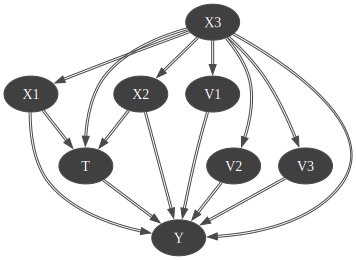

In [31]:
discretizer = disc.Discretizer(defaultDiscretizationMethod="uniform", defaultNumberOfBins=10)
discretizer.setDiscretizationParameters("Y", "uniform", 60)

bn = discretizer.discretizedTemplate(df)

bn.beginTopologyTransformation()
for _, name in bn:
  if name != "Y":
    bn.addArc(name, "Y")
for X in ["X1", "X2", "X3"]:
  bn.addArc(X, "T")
for XV in ["X1", "V1", "X2", "V2"]:
  bn.addArc("X3", XV)
bn.addArc("X3", "V3")
bn.endTopologyTransformation()

causal_model = csl.CausalModel(bn)

cslnb.showCausalModel(causal_model, size="10")

In [32]:
cee = csl.CausalEffectEstimation(df, causal_model)

### 3.3 Causal Identification

In [33]:
cee.identifyAdjustmentSet(intervention="T", outcome="Y")

Backdoor adjustment found. 

Supported estimators include:
- CausalModelEstimator
- SLearner
- TLearner
- XLearner
- PStratification
- IPW


'Backdoor'

### 3.4 Causal Estimation

In [34]:
cee.fitCausalBNEstimator()
tau_hat = cee.estimateCausalEffect()

print(f"ACE linear = {tau_hat}, MAPE = {abs((tau_hat - 2) / 2 * 100)} %")

ACE linear = 1.4160592003182688, MAPE = 29.197039984086558 %


In [35]:
cee.fitSLearner()
tau_hat = cee.estimateCausalEffect()

print(f"ACE linear = {tau_hat}, MAPE = {abs((tau_hat - 2) / 2) * 100} %")

ACE linear = 2.0155708275155457, MAPE = 0.7785413757772863 %


In [36]:
cee.fitTLearner()
tau_hat = cee.estimateCausalEffect()

print(f"ACE linear = {tau_hat}, MAPE = {abs((tau_hat - 2) / 2) * 100} %")

ACE linear = 2.0101222863806334, MAPE = 0.5061143190316697 %


In [37]:
cee.fitIPW()
tau_hat = cee.estimateCausalEffect()

print(f"ACE linear = {tau_hat}, MAPE = {abs((tau_hat - 2) / 2) * 100} %")

ACE linear = 1.9853346433498826, MAPE = 0.7332678325058684 %


### 3.5 Structure Learning with imposed slice order

We will assess the performance of the `BNLearner` module to uncover the causal structure of the dataset. A slice order will be imposed on the variables to guide the learning process. Following the identification of the structure via the Structure Learning algorithm, we will proceed to estimate the causal effect based on the inferred structure.

In [38]:
template = discretizer.discretizedTemplate(df)

structure_learner = gum.BNLearner(df, template)
structure_learner.useNMLCorrection()
structure_learner.useSmoothingPrior(1e-9)
structure_learner.setSliceOrder([["X3", "X1", "X2", "V1", "V2", "V3"], ["T"], ["Y"]])

learned_bn = structure_learner.learnBN()
learned_causal_model = csl.CausalModel(learned_bn)

print(structure_learner)

Filename               : /var/folders/r1/pj4vdx_n4_d_xpsb04kzf97r0000gp/T/tmpxbq03cxf.csv
Size                   : (100000,8)
Variables              : X1[10], X2[10], X3[2], T[2], V1[10], V2[10], V3[2], Y[60]
Induced types          : False
Missing values         : False
Algorithm              : MIIC
Correction             : NML
Prior                  : Smoothing
Prior weight           : 0.000000
Constraint Slice Order : {T:1, X2:0, V3:0, V1:0, Y:2, X3:0, X1:0, V2:0}



In [39]:
gnb.sideBySide(gexpl.getInformation(learned_bn, size="50"), gnb.getInference(learned_bn, size="50"))

Subsequently, we will reuse the previously established pipeline to estimate the causal effect based on the identified structure.

In [40]:
cee = csl.CausalEffectEstimation(df, learned_causal_model)

In [41]:
cee.identifyAdjustmentSet(intervention="T", outcome="Y")

Backdoor adjustment found. 

Supported estimators include:
- CausalModelEstimator
- SLearner
- TLearner
- XLearner
- PStratification
- IPW


'Backdoor'

In [42]:
cee.fitCausalBNEstimator()
tau_hat = cee.estimateCausalEffect()

print(f"ACE linear = {tau_hat}, MAPE = {abs((tau_hat - 2) / 2 * 100)} %")

ACE linear = 1.3316148082087895, MAPE = 33.419259589560525 %


In [43]:
cee.fitSLearner()
tau_hat = cee.estimateCausalEffect()

print(f"ACE linear = {tau_hat}, MAPE = {abs((tau_hat - 2) / 2) * 100} %")

ACE linear = 2.0155708275155457, MAPE = 0.7785413757772863 %


In [44]:
cee.fitTLearner()
tau_hat = cee.estimateCausalEffect()

print(f"ACE linear = {tau_hat}, MAPE = {abs((tau_hat - 2) / 2) * 100} %")

ACE linear = 2.0101222863806334, MAPE = 0.5061143190316697 %


In [45]:
cee.fitIPW()
tau_hat = cee.estimateCausalEffect()

print(f"ACE linear = {tau_hat}, MAPE = {abs((tau_hat - 2) / 2) * 100} %")

ACE linear = 1.9853346433498826, MAPE = 0.7332678325058684 %


We observe that the results remain largely consistent when imposing a slice order on the variables. However, the `CausalBNEstimator` appears to be the most sensitive to structural changes, as it relies on the entire graph structure for its estimations.

### 3.6 Structure Learning with imposed slice order

Next, we will evaluate the estimations produced when allowing the algorithm to perform structure learning autonomously, without imposing any slice order.

In [46]:
template = discretizer.discretizedTemplate(df)

structure_learner = gum.BNLearner(df, template)
structure_learner.useNMLCorrection()
structure_learner.useSmoothingPrior(1e-9)

learned_bn = structure_learner.learnBN()
learned_causal_model = csl.CausalModel(learned_bn)

print(structure_learner)

Filename       : /var/folders/r1/pj4vdx_n4_d_xpsb04kzf97r0000gp/T/tmpwbnw5ili.csv
Size           : (100000,8)
Variables      : X1[10], X2[10], X3[2], T[2], V1[10], V2[10], V3[2], Y[60]
Induced types  : False
Missing values : False
Algorithm      : MIIC
Correction     : NML
Prior          : Smoothing
Prior weight   : 0.000000



In [47]:
gnb.sideBySide(gexpl.getInformation(learned_bn, size="50"), gnb.getInference(learned_bn, size="50"))

We are encountering challenges at the outset, as numerous causal relationships are misspecified, with multiple covariates incorrectly identified as causes of the outcome. Despite this, the intervention variable is correctly identified as a cause of the outcome. With limited expectations, let us now examine the estimation results.

In [48]:
cee = csl.CausalEffectEstimation(df, learned_causal_model)

In [49]:
cee.identifyAdjustmentSet(intervention="T", outcome="Y")

Randomized Controlled Trial adjustment found. 

Supported estimators include:
- CausalModelEstimator
- DM
If the outcome variable is a cause of other covariates in the causal graph,
Backdoor estimators may also be used.


'Randomized Controlled Trial'

In [50]:
cee.fitCausalBNEstimator()
tau_hat = cee.estimateCausalEffect()

print(f"ACE linear = {tau_hat}, MAPE = {abs((tau_hat - 2) / 2 * 100)} %")

ACE linear = 0.8986373014279513, MAPE = 55.06813492860243 %


In [51]:
cee.fitDM()
tau_hat = cee.estimateCausalEffect()

print(f"ACE linear = {tau_hat}, MAPE = {abs((tau_hat - 2) / 2) * 100} %")

ACE linear = -2.8429232775624858, MAPE = 242.1461638781243 %


The results are exceptionally poor. In an attempt to address this issue, we will investigate whether controlling for covariates that are identified as causes of the outcome in the causal graph improves the estimation.

In [52]:
cee.useBackdoorAdjustment(intervention="T", outcome="Y", confounders={"V1", "V2"})

In [53]:
cee.fitSLearner()
tau_hat = cee.estimateCausalEffect()

print(f"ACE linear = {tau_hat}, MAPE = {abs((tau_hat - 2) / 2) * 100} %")

ACE linear = 1.0111974675217072, MAPE = 49.44012662391464 %


In [54]:
cee.fitTLearner()
tau_hat = cee.estimateCausalEffect()

print(f"ACE linear = {tau_hat}, MAPE = {abs((tau_hat - 2) / 2) * 100} %")

ACE linear = 1.0439470803665345, MAPE = 47.80264598167327 %


One might assume that the estimation methods are not sufficiently sophisticated, given that the default meta-learners utilize Linear Regression as the base model. To address this, we will assess whether employing `XGBRegressor` as the base learner within the `XLearner` framework improves the estimation results.

In [55]:
cee.fitXLearner(learner="XGBRegressor")
tau_hat = cee.estimateCausalEffect()

print(f"ACE linear = {tau_hat}, MAPE = {abs((tau_hat - 2) / 2) * 100} %")

ACE linear = 1.0536299230091695, MAPE = 47.31850384954153 %


The results show only marginal improvement, insufficient to draw reliable conclusions about the true causal effect.

This underscores the critical role of domain knowledge in accurately specifying the underlying causal structure. Even the most sophisticated estimation methods can falter when the causal structure is incorrectly specified.